In [22]:
import os
import json
import pandas as pd
from torch.utils.data import DataLoader
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor as tt
from torchvision.utils import make_grid
from tqdm import tqdm
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [23]:
!pip install torchsummary

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [24]:
BATCH_SIZE = 128
NUM_EPOCHS = 20
LEARNING_RATE = 0.0001
ROOT_DIR = "/kaggle/input/bonemarrowdatasetprocessed-for-classification-task/data_processed/"

In [25]:
train_df = pd.read_csv(f"{ROOT_DIR}data/train.csv")
val_df = pd.read_csv(f"{ROOT_DIR}data/val.csv")
test_df = pd.read_csv(f"{ROOT_DIR}data/test.csv")

train_df.shape, val_df.shape, test_df.shape

((119961, 3), (16967, 3), (34446, 3))

In [26]:
class BMDataset():
    
    def __init__(self, dataframe, shape=(224, 224), system = "windows"):
        self.dataframe = dataframe
        self.shape = shape
        if system == "linux":
            self.dataframe["path"] = self.dataframe["path"].apply(self.process_path_on_linux)
    
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        path = os.path.join(ROOT_DIR, self.dataframe.iloc[idx, 0])
        label = self.dataframe.iloc[idx, 2]
        img = self._load_img(path)

        return img, label
    
    def process_path_on_linux(self, path):
        return "/".join(path.split("\\"))

    def _load_img(self, path):
        img = Image.open(path)
        img = img.resize(self.shape)
        img = tt()(img)
        return img


train_ds = BMDataset(train_df, system="linux")
val_ds = BMDataset(val_df,system="linux")
test_ds = BMDataset(test_df, system="linux")

In [27]:
train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True, drop_last = False)
val_dl = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle=True, drop_last = False)
test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle=True, drop_last = False)

In [28]:
rand_train_batch_image, rand_train_batch_labels = next(iter(train_dl))
rand_train_batch_image.shape, rand_train_batch_labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [29]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms import Resize

In [30]:
class BMBaseModel(nn.Module):

    def __init__(self, network, num_classes):
        super(BMBaseModel, self).__init__()
        if network == "resnet":
            self.featurizer = torch.hub.load('pytorch/vision:v0.10.0', "resnet18", pretrained=True)
        elif network == "inception":
            self.featurizer = torch.hub.load('pytorch/vision:v0.10.0', 'inception', pretrained=True)
        elif network == "googlenet":
            self.featurizer = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
        #self.featurizer = self._freeze_layers(self.featurizer)
        self.mid_blocks = nn.Sequential(
                nn.Linear(1000, 2048),
                nn.Linear(2048, 1024),
                nn.Linear(1024, 256),
        )
        self.output_layer = nn.Linear(256, num_classes)

    def _freeze_layers(self, network):
        for param in network.parameters():
            param.requires_grad = False
        return network
    
    def forward(self, x):
        featurizer_op = self.featurizer(x)
        flattened_op = featurizer_op.view(featurizer_op.shape[0], -1)
        return self.output_layer(self.mid_blocks(flattened_op))

In [31]:
from torchsummary import summary

exp1model = BMBaseModel("resnet", 21)

summary(exp1model, (3, 224, 224), batch_size=BATCH_SIZE, device="cpu")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 112, 112]           9,408
       BatchNorm2d-2        [128, 64, 112, 112]             128
              ReLU-3        [128, 64, 112, 112]               0
         MaxPool2d-4          [128, 64, 56, 56]               0
            Conv2d-5          [128, 64, 56, 56]          36,864
       BatchNorm2d-6          [128, 64, 56, 56]             128
              ReLU-7          [128, 64, 56, 56]               0
            Conv2d-8          [128, 64, 56, 56]          36,864
       BatchNorm2d-9          [128, 64, 56, 56]             128
             ReLU-10          [128, 64, 56, 56]               0
       BasicBlock-11          [128, 64, 56, 56]               0
           Conv2d-12          [128, 64, 56, 56]          36,864
      BatchNorm2d-13          [128, 64, 56, 56]             128
             ReLU-14          [128, 64,

In [32]:
chkp = torch.load(f"/kaggle/input/bonemarrowdatasetprocessed-for-classification-task/exp1_best.pt")
exp1model.load_state_dict(chkp["model"])

<All keys matched successfully>

In [33]:
exp1model.eval()
exp1model = exp1model.cuda()

In [34]:
def predict(model, dl):
    true = []
    pred = []
    for batch, labels in tqdm(dl):
        op = model(batch.cuda())
        true += labels.detach().numpy().tolist()
        pred += torch.argmax(op, dim=1).cpu().detach().numpy().tolist()
        del op, batch
    return true, pred

In [35]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report

In [36]:
cols = ["ABE", "ART","BAS", "BLA", "EBO", "EOS", "FGC", "HAC", "KSC", "LYI", "LYT", "MMZ", "MON", "MYB", "NGB", "NGS", "NIF", "OTH", "PEB", "PLM", "PMO"]

100%|██████████| 938/938 [11:47<00:00,  1.33it/s]


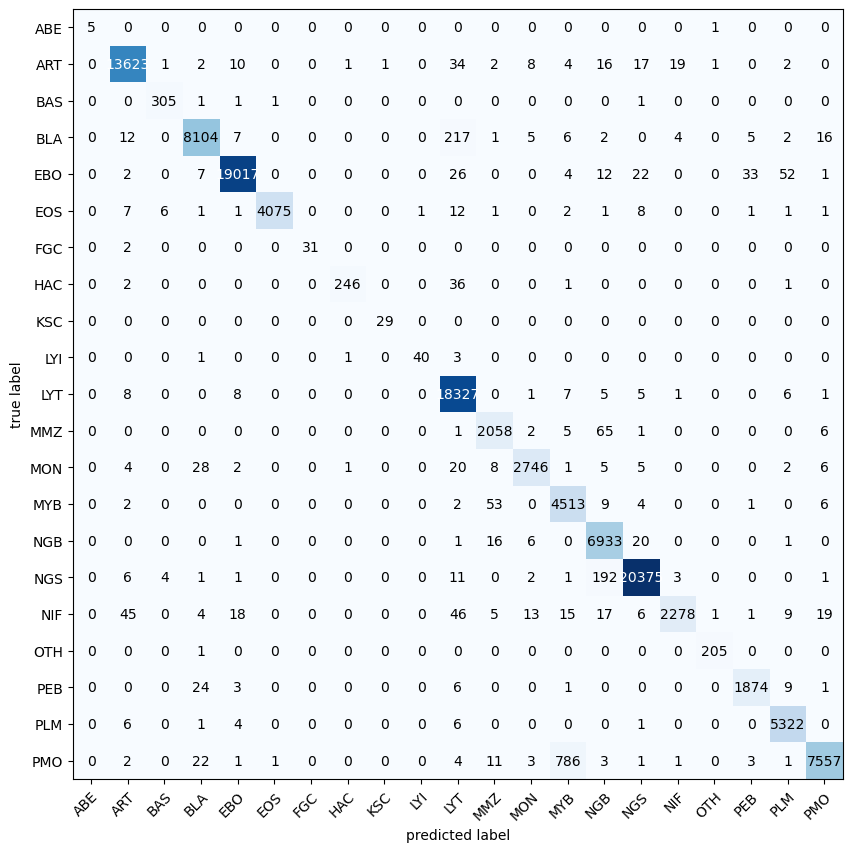

In [37]:
train_true, train_pred = predict(exp1model, train_dl)
plot_confusion_matrix(confusion_matrix(train_true, train_pred), figsize=(10, 10), class_names=cols)
plt.savefig("train_conf_mat.png")

100%|██████████| 133/133 [01:38<00:00,  1.36it/s]


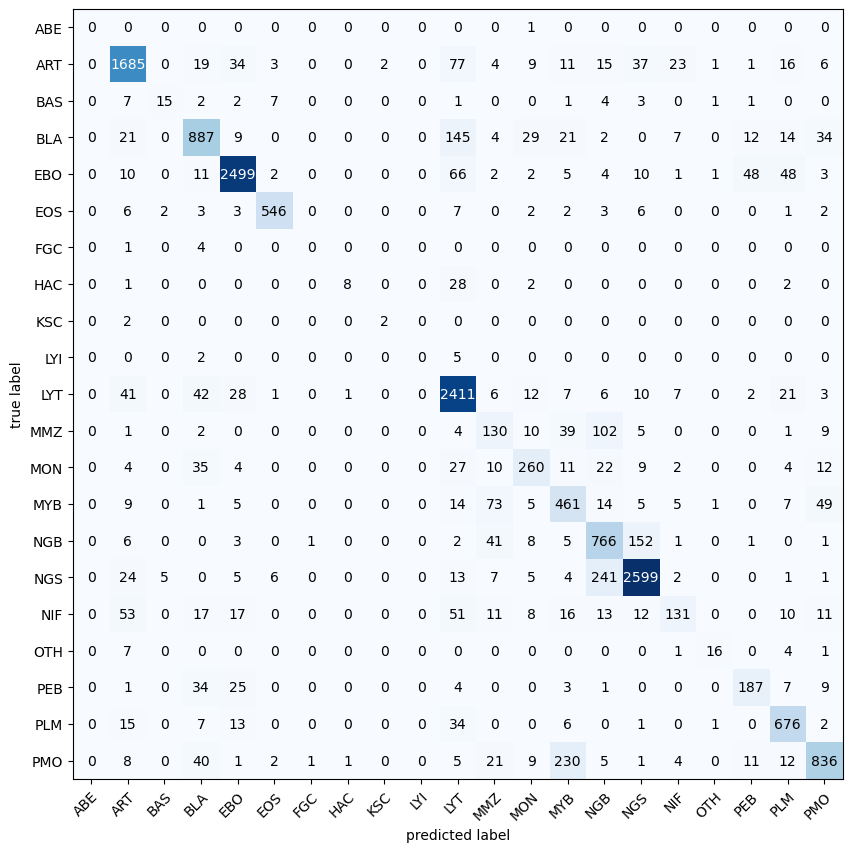

In [38]:
val_true, val_pred = predict(exp1model, val_dl)
plot_confusion_matrix(confusion_matrix(val_true, val_pred), figsize=(10, 10), class_names=cols)
plt.savefig("val_conf_mat.png")

100%|██████████| 270/270 [03:23<00:00,  1.33it/s]


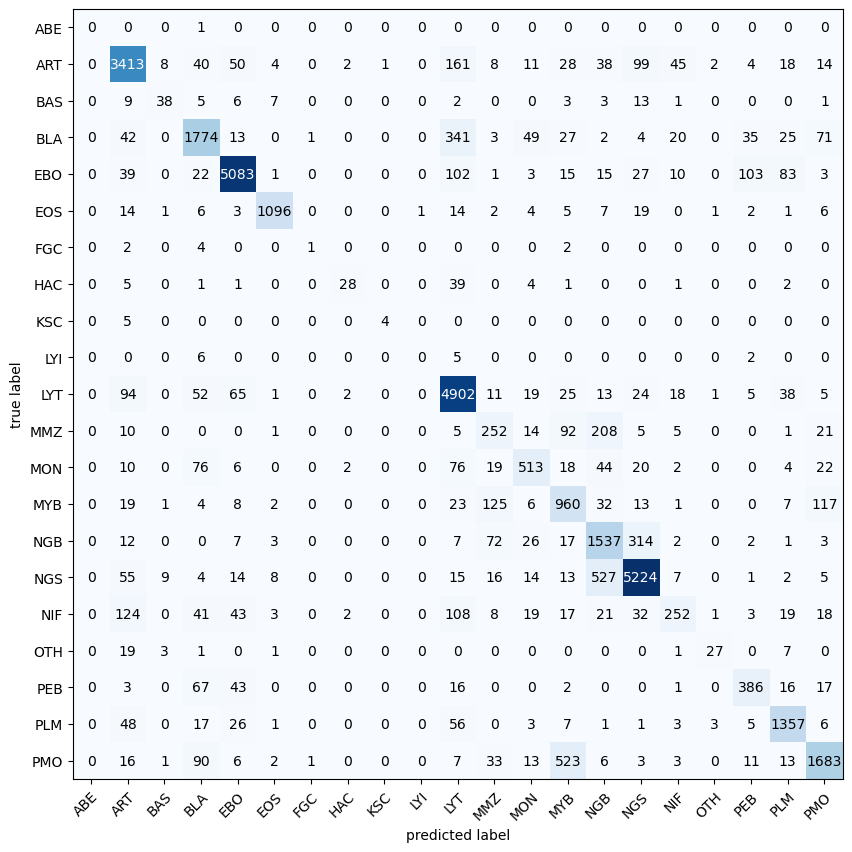

In [39]:
test_true, test_pred = predict(exp1model, test_dl)
plot_confusion_matrix(confusion_matrix(test_true, test_pred), figsize=(10, 10), class_names=cols)
plt.savefig("test_conf_mat.png")

In [40]:
classification_report(train_true, train_pred)

'              precision    recall  f1-score   support\n\n           0       1.00      0.83      0.91         6\n           1       0.99      0.99      0.99     13741\n           2       0.97      0.99      0.98       309\n           3       0.99      0.97      0.98      8381\n           4       1.00      0.99      0.99     19176\n           5       1.00      0.99      0.99      4118\n           6       1.00      0.94      0.97        33\n           7       0.99      0.86      0.92       286\n           8       0.97      1.00      0.98        29\n           9       0.98      0.89      0.93        45\n          10       0.98      1.00      0.99     18369\n          11       0.95      0.96      0.96      2138\n          12       0.99      0.97      0.98      2828\n          13       0.84      0.98      0.91      4590\n          14       0.95      0.99      0.97      6978\n          15       1.00      0.99      0.99     20597\n          16       0.99      0.92      0.95      2477\n       

In [41]:
classification_report(val_true, val_pred)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00         1\n           1       0.89      0.87      0.88      1943\n           2       0.68      0.34      0.45        44\n           3       0.80      0.75      0.77      1185\n           4       0.94      0.92      0.93      2712\n           5       0.96      0.94      0.95       583\n           6       0.00      0.00      0.00         5\n           7       0.80      0.20      0.31        41\n           8       0.50      0.50      0.50         4\n           9       0.00      0.00      0.00         7\n          10       0.83      0.93      0.88      2598\n          11       0.42      0.43      0.42       303\n          12       0.72      0.65      0.68       400\n          13       0.56      0.71      0.63       649\n          14       0.64      0.78      0.70       987\n          15       0.91      0.89      0.90      2913\n          16       0.71      0.37      0.49       350\n       

In [42]:
classification_report(test_true, test_pred)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00         1\n           1       0.87      0.86      0.87      3946\n           2       0.62      0.43      0.51        88\n           3       0.80      0.74      0.77      2407\n           4       0.95      0.92      0.93      5507\n           5       0.97      0.93      0.95      1182\n           6       0.33      0.11      0.17         9\n           7       0.78      0.34      0.47        82\n           8       0.80      0.44      0.57         9\n           9       0.00      0.00      0.00        13\n          10       0.83      0.93      0.88      5275\n          11       0.46      0.41      0.43       614\n          12       0.73      0.63      0.68       812\n          13       0.55      0.73      0.62      1318\n          14       0.63      0.77      0.69      2003\n          15       0.90      0.88      0.89      5914\n          16       0.68      0.35      0.47       711\n       